#### Build a machine learning model to predict user engagement using the target metric

Steps:
- Label creation
- Create classifier logic from metric definition
- Univarate Analysis
- Bivarate Analysis
- Class Imbalance check
- Missing Value Treatment
- Feature Engineering
- Correlation
- Split-out Training and Validation dataset
- Feature Selection
- Evaluate Algorithms
- Model Tuning
- Feature Importances

In [1]:
# Import the neccessary modules for data manipulation and visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree

In [3]:
from sklearn.metrics import roc_curve

In [4]:
# load datasets
df_users = pd.read_csv('../data/users.csv', parse_dates=['created_date'])
df_transactions = pd.read_csv('../data/transactions.csv', parse_dates=['created_date'])

#### Descriptive analytics

Data quality checks were carried out in the "target_metrics_analysis" notebook, here further descriptive statistics will be done

In [5]:
# summary stat
df_transactions.astype('object').describe().transpose()

,count,unique,top,freq
transaction_id,2740075,2740075,transaction_670150,1
transactions_type,2740075,10,CARD_PAYMENT,1475780
transactions_currency,2740075,35,EUR,1160135
amount,2.74008e+06,48548,0,58604
merchant_country,1581096,198,GBR,455924
user_id,2740075,18766,user_12657,5285
created_date,2740075,2739658,2018-12-04 12:13:34.572326,4


From the transaction summary stat above:
- **transactions_type** as 10 unique values and the most occurring of them is 'CARD_PAYMENT'
- **transactions_currency** as 35 different types of currencies and the most used currency is 'EUR'
- **merchant_country** contains 198 unique values and 'GBR' as higest count
- **user_id** as 18766 users, of all the users user_12657 as the higest transaction count

In [6]:
# summary stat
df_users.astype('object').describe().transpose()

,count,unique,top,freq
user_id,19430,19430,user_251,1
birth_year,19430,69,1992,955
country,19430,41,GB,6315
created_date,19430,19430,2018-10-21 04:30:07.620055,1
plan,19430,6,STANDARD,17992


From the user summary stat above:
- **birth_year** as 69 unique values and the most occurring value is '1992'. A lot of users entered '1992' as their birth year.
- **country** as 41 different types of countries and the most occurring is 'GB'
- **plan** contains 6 unique values and 'STANDARD' as higest count

In [7]:
# Check the data type of the features for any inconsistencies
print('-------Users-------')
df_users.info()
print(' ')
print('-------Transactions-------')
df_transactions.info()

-------Users-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19430 entries, 0 to 19429
Data columns (total 5 columns):
user_id         19430 non-null object
birth_year      19430 non-null int64
country         19430 non-null object
created_date    19430 non-null datetime64[ns]
plan            19430 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 759.1+ KB
 
-------Transactions-------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740075 entries, 0 to 2740074
Data columns (total 7 columns):
transaction_id           object
transactions_type        object
transactions_currency    object
amount                   float64
merchant_country         object
user_id                  object
created_date             datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 146.3+ MB


#### Label the data
An engaged user can be defined as a user that carries out transactions via any of the listed GemStones products above in a month.<br>
Monthly Active Users (MAU) = total number of unique active users in a month<br>
An unengaged user can be defined as a user that does not carry out any transaction in a month.<br>
In creating a machine learning classifer, the classifier logic will be built off of the earlier definition of engagement.

#### Create classifier logic from metric definition

In [8]:
# Create year_month feature from created_date
df_transactions['year_month'] = df_transactions['created_date'].dt.to_period('M')
df_transactions.head()

,transaction_id,transactions_type,transactions_currency,amount,merchant_country,user_id,created_date,year_month
0,transaction_0,TRANSFER,AED,4.55,NaN,user_898,2018-04-03 03:34:21.784487,2018-04
1,transaction_1,CARD_PAYMENT,AED,15.50,ARE,user_1652,2019-03-19 06:15:59.537032,2019-03
2,transaction_2,CARD_PAYMENT,AED,43.40,ARE,user_1652,2019-03-18 18:53:41.323032,2019-03
3,transaction_3,TRANSFER,AED,10043.01,NaN,user_1652,2019-03-22 14:20:01.513032,2019-03
4,transaction_4,CARD_PAYMENT,AED,43.81,ARE,user_5509,2019-03-22 05:42:50.316652,2019-03


In [9]:
# Aggregate records
df_transactions_grouped = df_transactions.groupby(by=['year_month','user_id'], as_index=False).count()[['year_month','user_id']]
df_transactions_grouped.rename(columns={"year_month": "month"}, inplace=True)
df_transactions_grouped.head()

,month,user_id
0,2018-01,user_0
1,2018-01,user_1
2,2018-01,user_10
3,2018-01,user_100
4,2018-01,user_1000


In [10]:
def plot_attribute(df, attribute,title_text,hue_attribute=None):
    '''plots a seaborn countplot'''
    
    sns.set(style="whitegrid",font_scale=1.3)

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 8))

    # Plot the total user per city
    sns.set_color_codes("pastel")
    
    if hue_attribute == 'engaged':
        sns.countplot(x=attribute, data=df, color="royalblue",hue=hue_attribute,order=df[attribute].value_counts().index);
    else:
        sns.countplot(x=attribute, data=df, color="royalblue", alpha=0.8,order=df[attribute].value_counts().index);
        
    # Add informative axis label
    ax.set(title=title_text+' '+attribute, xlabel=attribute)
    sns.despine(left=True, bottom=True)
    
    ax.set(xlabel=attribute, ylabel='Frequency')

In [11]:
def get_user_activity_count(user_id, df_trx):
    '''extracts the transactions of a selected'''    
    
    return len(df_trx[df_trx['user_id']== user_id])

In [12]:
def get_user_inactivity_count(user_id, df_trx, df_month_list):
    '''get user inactive months using list of months user was active'''    
    
    # get the user's active months
    df_user_active_months = df_trx[df_trx['user_id']== user_id][['month']]
    
    # get the user's in active months    
    df_months = df_month_list[~df_month_list['month'].isin(df_user_active_months.month.to_list())]
    
    count = 0
    if len(df_months) > 0:
        count = df_months.nunique().values[0]
     
    return count

In [13]:
def get_inactivity_percentage(active_counts,inactive_counts):
    '''calculate proportion of inactivity'''
    return (inactive_counts/(active_counts + inactive_counts)) * 100

In [14]:
# set engagement flag (the ideal threshold will be best gotten from multiply experiments using various 
# threshold values in line with what business stakeholders believe will move the engagement metrics niddle)
# for this project I used a threshold of 60%, meaning if a user is inactive 60% of the time, the user is labeled unengaged. 
def get_engagement_label(inactivity_percentage):
    '''returns the classification label (0 = not engaged and 1 = engaged) '''
    if(inactivity_percentage >= 60):
        return 0
    else:
        return 1

In [15]:
# Dataframe to hold engagement computations, this will contain the various aggregations and new features created
df_user_activities = pd.DataFrame(data = df_users.user_id.unique(), columns=['user_id'])

In [16]:
# Get active count for each user
df_user_activities['active_count'] = df_user_activities.apply(lambda row: get_user_activity_count(row['user_id'], 
                                                                                                 df_transactions_grouped), axis=1)

df_user_activities.head()

,user_id,active_count
0,user_0,17
1,user_1,12
2,user_2,11
3,user_3,10
4,user_4,7


The table above shows the number of months the users were active

In [17]:
# Extract unique list of months from the dataset to use in computing engagement
df_all_months = df_transactions_grouped[['month']]
df_all_months = pd.DataFrame(data=df_all_months.groupby(by='month').count()).reset_index()

In [18]:
# Get user's inactive_count
df_user_activities['inactive_count'] = df_user_activities.apply(lambda row: get_user_inactivity_count(row['user_id'], 
                                                                                                 df_transactions_grouped, df_all_months), axis=1)

df_user_activities.head()

,user_id,active_count,inactive_count
0,user_0,17,0
1,user_1,12,5
2,user_2,11,6
3,user_3,10,7
4,user_4,7,10


The table above shows the number of months the users were active and inactive.

Looking at sample records: 
- User user_0 was active in 17 months out of all the 17 months observed
- User user_3 was active in 10 months and inactive in 7 months


In [19]:
# Get user's inactivity_percent
df_user_activities['inactivity_percent'] = df_user_activities.apply(lambda row: get_inactivity_percentage(row['active_count'], 
                                                                                                 row['inactive_count']), axis=1)

df_user_activities.head()

,user_id,active_count,inactive_count,inactivity_percent
0,user_0,17,0,0.000000
1,user_1,12,5,29.411765
2,user_2,11,6,35.294118
3,user_3,10,7,41.176471
4,user_4,7,10,58.823529


In [20]:
# Label user engagement based on user's that are inactive 60% of the time
df_user_activities['engaged'] = df_user_activities.apply(lambda row: get_engagement_label(row['inactivity_percent']), axis=1)
df_user_activities.head()

,user_id,active_count,inactive_count,inactivity_percent,engaged
0,user_0,17,0,0.000000,1
1,user_1,12,5,29.411765,1
2,user_2,11,6,35.294118,1
3,user_3,10,7,41.176471,1
4,user_4,7,10,58.823529,1


In the above table, the users are now labelled in the 'engaged' field based on the defined logic

In [21]:
df_user_activities.groupby(by='engaged').size()

engaged
0    10683
1     8747
dtype: int64

In [22]:
#df_user_activities_ = df_user_activities.copy()

In [23]:
# add birth_year attribute to df_user_activities
df_user_activities['birth_year'] = df_users[['birth_year']]

#### Univarate analysis

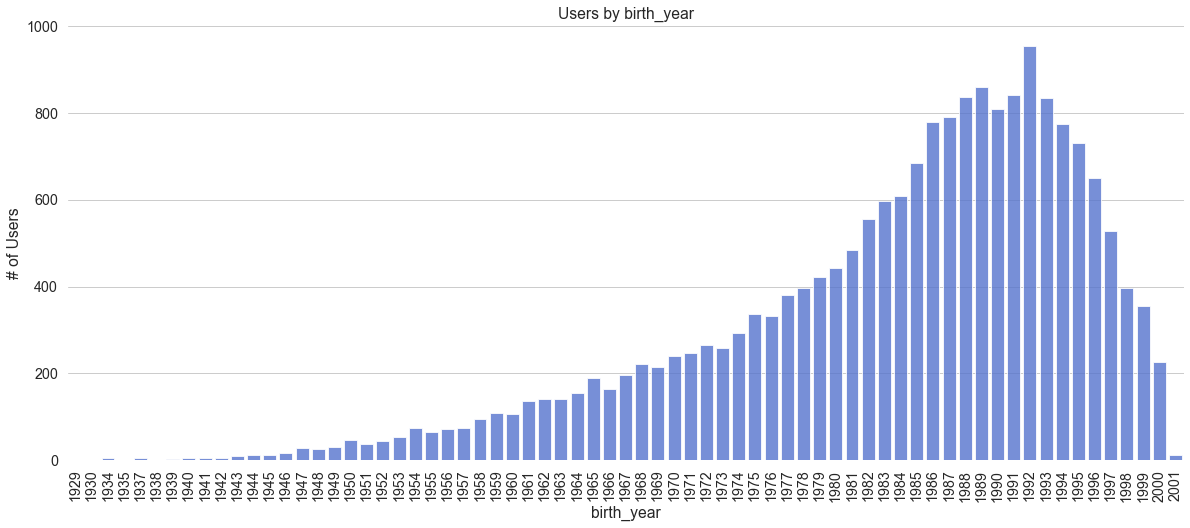

In [24]:
# visualize birth_year
sns.set(style="whitegrid",font_scale=1.3)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 8))

sns.set_color_codes("pastel")
sns.countplot(x='birth_year', data=df_users, color="royalblue",alpha=0.8)
plt.xticks(rotation = 90);

# Add informative axis label
ax.set(ylabel="# of Users", title='Users by birth_year', xlabel='birth_year')
sns.despine(left=True, bottom=True)

From the distribution of users by birth year, majority of the users have their birth year between 1982 - 1997. It is also observed that 1992 has the highest number of users. A large popopulation of the user base are millennials, the serivces from gemstones as a good acceptance rate or resonates well with this age group.


<i>Millennials, also known as Generation Y, are the demographic cohort following Generation X and preceding Generation Z. Researchers and popular media use the early 1980s as starting birth years and the mid-1990s to early 2000s as ending birth years, with 1981 to 1996 a widely accepted defining range for the generation. Wikipedia<i>

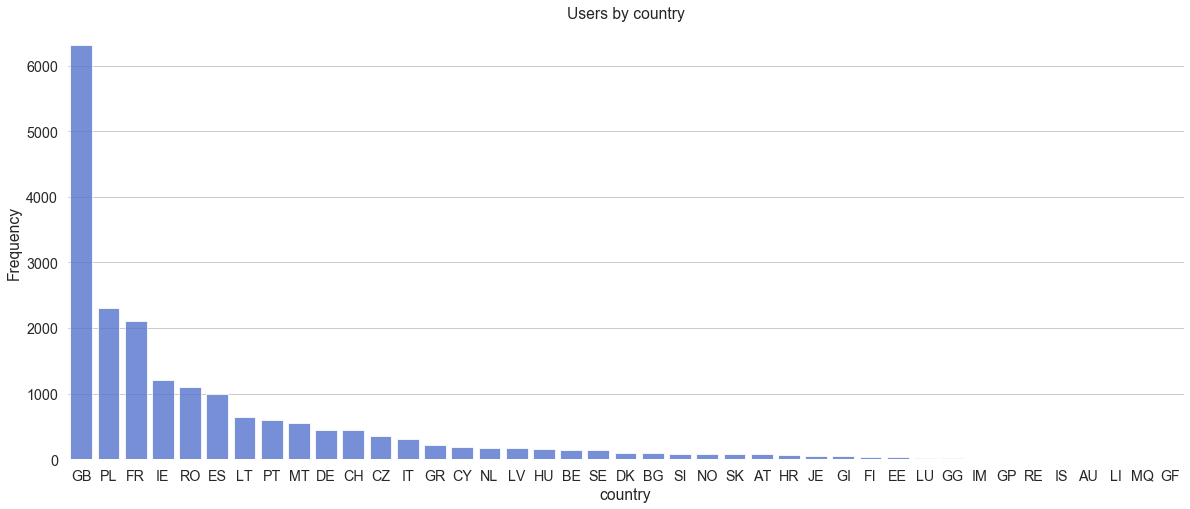

In [25]:
# Plot the distribution country
plot_attribute(df_users,'country','Users by')

Great Britain has the highest number of users, this could be because GemStones started from GB and has a strong presence there. Looking at the plot, gradual advancement are being made into other countries, the numbers will increase with the execution of targeted marketing campaigns. From the user birth year plot above, the bulk of the user base are between 1979 - 2000, they are largely young individuals, there is a possibility that over 80% of them use Facebook. Facebook has almost 2.5 billion monthly active users as of the fourth quarter of 2019. Facebook's AD services could be used to target "look alike customers" there by improving growth and user engagement.

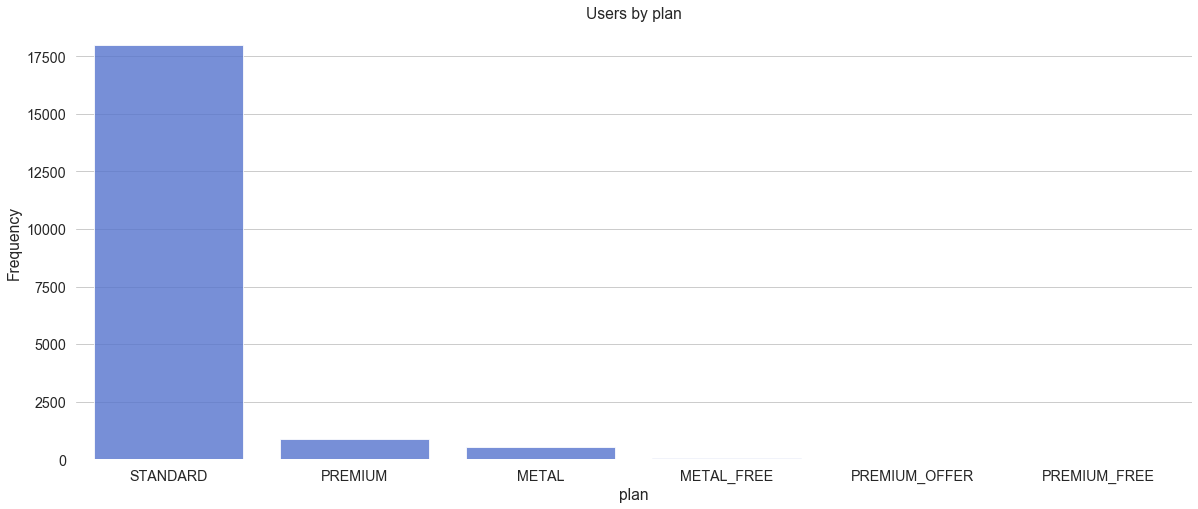

In [26]:
# Plot the distribution plan
plot_attribute(df_users,'plan','Users by')

The Standard plan is the highest here, I believe this is so because it is free £0/m, and has a enough features to keep users. We could personalize the value of the premium plan and upsell to the customers on the standard plan, or we could get the profiles of the users in the premium plan and use the Facebook AD services to target "look alike customers"

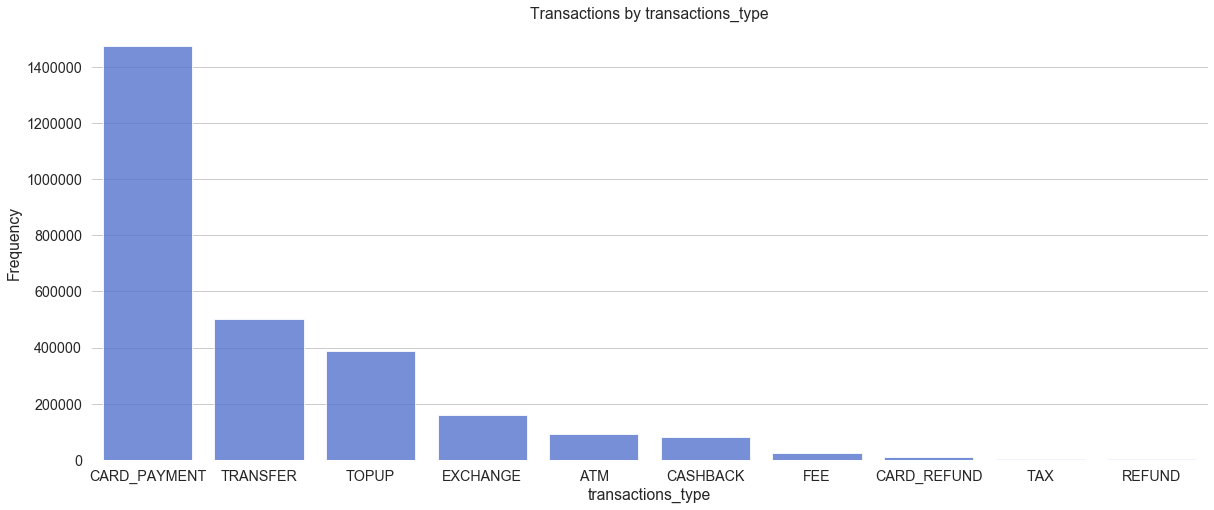

In [87]:
#Plot the distribution transactions_type
plot_attribute(df_transactions,'transactions_type','Transactions by')

Card Payment is the highest here, this is likely because users carry out day to day transactions like paying for goods services more than other transaction types.

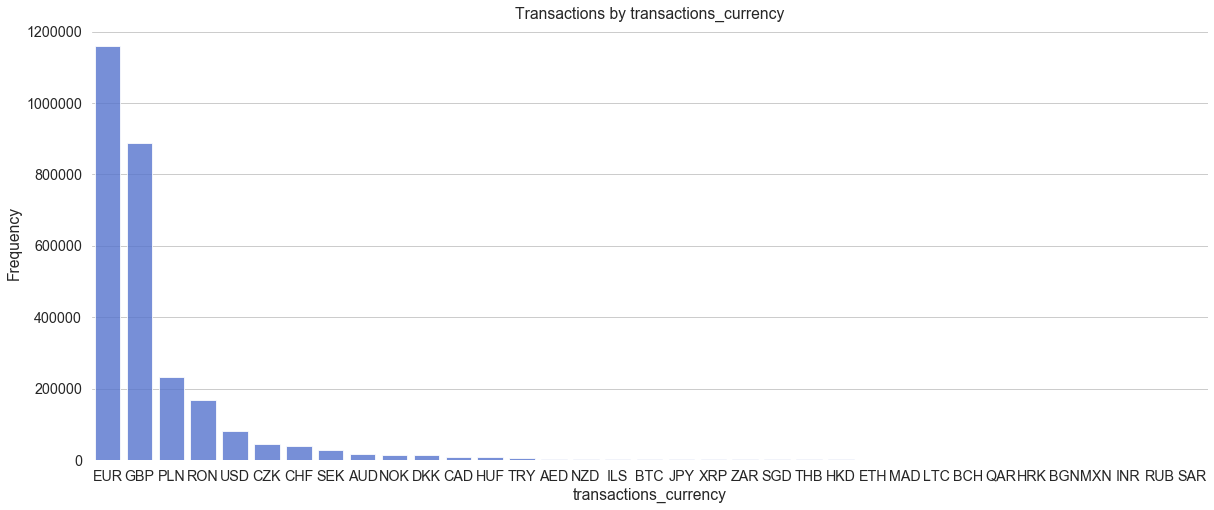

In [88]:
#Plot the distribution transactions_currency
plot_attribute(df_transactions,'transactions_currency','Transactions by')

The top 2 currencies in use here are the EUR and GBP.

In [29]:
# Todo: Plot the distribution merchant

#### Bivarate analysis

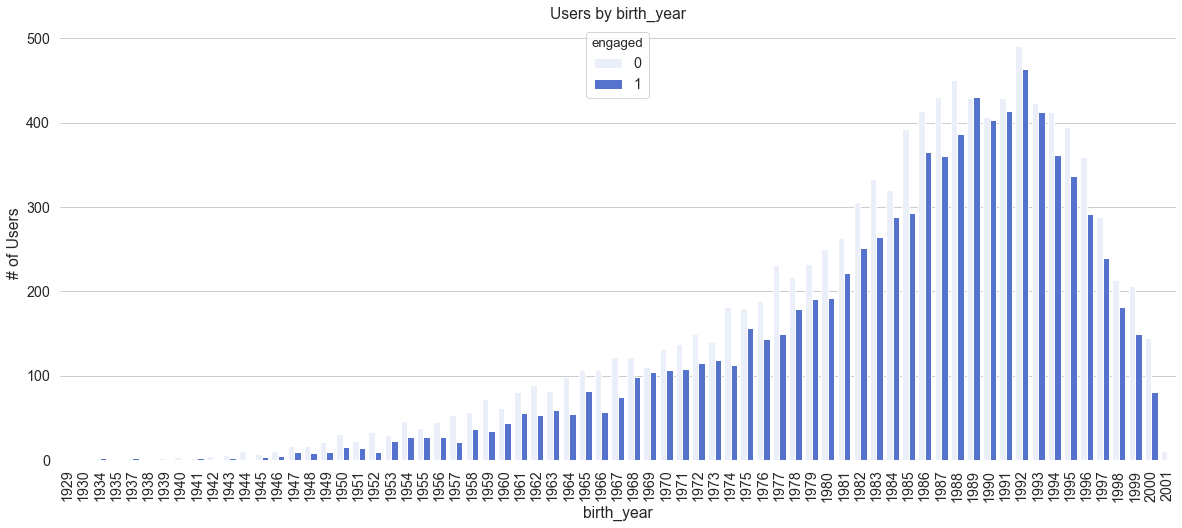

In [30]:
# visualize birth_year by engagement
sns.set(style="whitegrid",font_scale=1.3)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 8))

sns.set_color_codes("pastel")
sns.countplot(x='birth_year', data=df_user_activities, color="royalblue",hue='engaged')
plt.xticks(rotation = 90);

# Add informative axis label
ax.set(ylabel="# of Users", title='Users by birth_year', xlabel='birth_year')
sns.despine(left=True, bottom=True)

From the distribution of users by birth year, the inactivity observed spans across every age group represented.

In [31]:
# set the 'engaged' value for each transaction of each user, this is needed for visualization
df_transactions= df_transactions.merge(df_user_activities[['user_id','engaged']],how='inner',on='user_id')

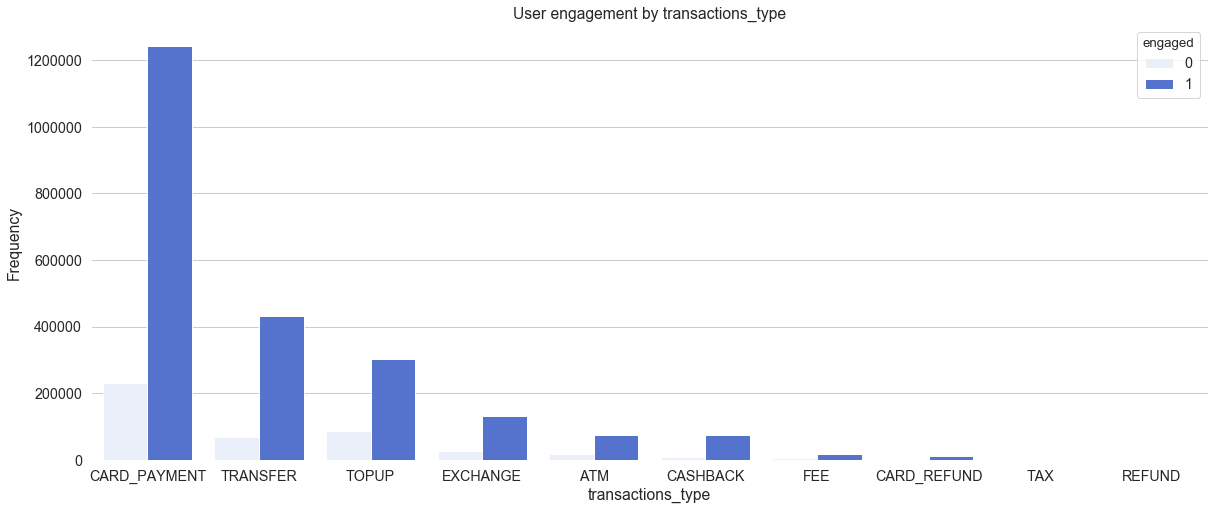

In [90]:
# visualize transactions_type by engagement
plot_attribute(df_transactions,'transactions_type','User engagement by','engaged')

The top payment type 'Card_Payment' as about over 70% of the transactions done by users that are engaged

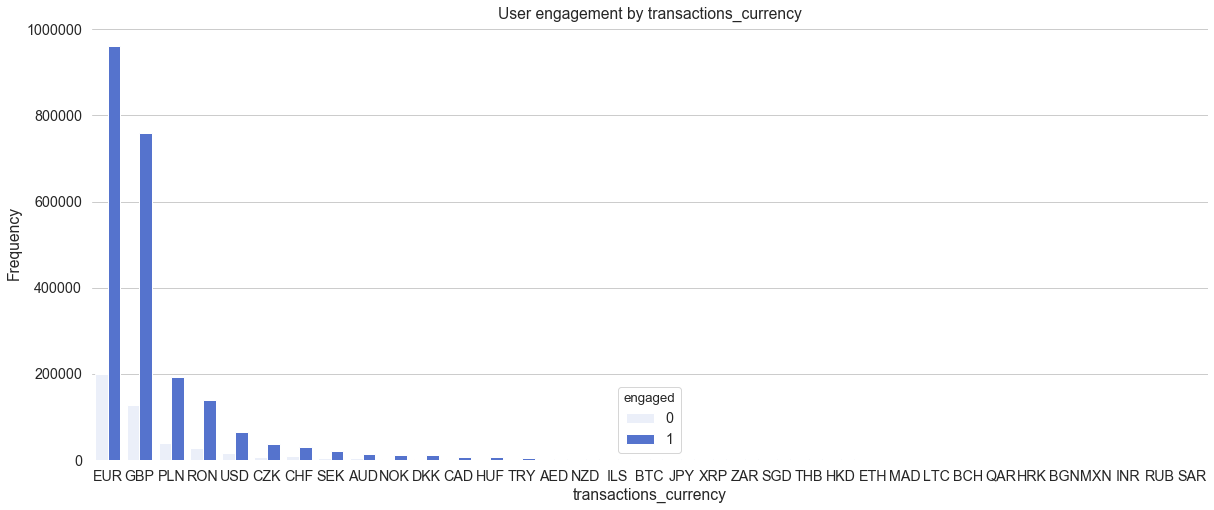

In [91]:
# visualize transactions_currency by engagement
plot_attribute(df_transactions,'transactions_currency','User engagement by','engaged')

The 'EUR' and 'GBP' currencies are the top currencies and a large percentage of the transactions done in these currencies were done by engaged users

In [34]:
# Todo: df_transaction.groupby('transactions_currency').agg({'amount': ['sum']}).reset_index()

#### Class Imbalance
Class imbalance is a major challenge that can affect the result of model training and inference.

In [35]:
# A check for class imbalance is done
df_user_activities.engaged.value_counts(1)

0    0.54982
1    0.45018
Name: engaged, dtype: float64

The user unenaged rate is 54%
This is a void of oppurtunity that can be filled, further analysis can be done to know what ways could be experimented  on to know the trigger to pull to make users become more engaged, finding this out and excuting a plan will have a direct impact to the revenue and growth of the buisness

#### Missing Value Treatment

The field ea_merchant_country will be treated with 'Others' where the values are missing

In [36]:
df_transactions.merchant_country.fillna('Others',inplace=True)

#### Feature Engineering

In [37]:
# Aggregate the amount_usd attribute
df_transactions_aggregate = df_transactions[['user_id','amount']].groupby('user_id').agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

In [38]:
# create new column names for created features
columns = ['user_id']
# Iterate through the variables names
for var in df_transactions_aggregate.columns.levels[0]:
    # Skip the grouping variable
    if var != 'user_id':
        # Iterate through the stat names
        for stat in df_transactions_aggregate.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

df_transactions_aggregate.columns = columns

In [39]:
# Get the number of unique transaction types the users engaged with
df_user_transation_types = (df_transactions[['user_id','transactions_type']].groupby('user_id')['transactions_type'].nunique()).reset_index()
df_user_transation_types.head()

,user_id,transactions_type
0,user_0,7
1,user_1,5
2,user_10,7
3,user_100,5
4,user_1000,4


In [40]:
# Merge aggregated data with the df_user_activities data
df_user_activities = df_user_activities.merge(df_user_transation_types, how='left', on='user_id')

In [41]:
# Get the number of unique transaction currencies the user engaged with
df_user_transactions_currency = (df_transactions[['user_id','transactions_currency']].groupby('user_id')['transactions_currency'].nunique()).reset_index()
df_user_transactions_currency.head()

,user_id,transactions_currency
0,user_0,5
1,user_1,1
2,user_10,1
3,user_100,2
4,user_1000,3


In [42]:
# Merge aggregated data with the df_user_activities data
df_user_activities = df_user_activities.merge(df_user_transactions_currency, how='left', on='user_id')

In [43]:
# merge aggregated data with the df_user_activities data
df_user_activities = df_user_activities.merge(df_transactions_aggregate, how='left', on='user_id')

In [44]:
# Extract features from the 'created_date' attribute
df_user_activities['created_date_day'] = df_users['created_date'].dt.day
df_user_activities['created_date_week'] = df_users['created_date'].dt.week
df_user_activities['created_date_month'] = df_users['created_date'].dt.month
df_user_activities['created_date_year'] = df_users['created_date'].dt.year

In [45]:
#Dummy encoding:
df_user_plan = pd.get_dummies(df_users[['plan']])
df_user_plan.head()

,plan_METAL,plan_METAL_FREE,plan_PREMIUM,plan_PREMIUM_FREE,plan_PREMIUM_OFFER,plan_STANDARD
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


In [46]:
df_user_activities = pd.concat([df_user_activities, df_user_plan], axis=1)

In [47]:
# fill up NaN created during merge actions
df_user_activities.fillna(0, inplace=True)

In [48]:
df_user_activities.isna().sum()

user_id                  0
active_count             0
inactive_count           0
inactivity_percent       0
engaged                  0
birth_year               0
transactions_type        0
transactions_currency    0
amount_count             0
amount_mean              0
amount_max               0
amount_min               0
amount_sum               0
created_date_day         0
created_date_week        0
created_date_month       0
created_date_year        0
plan_METAL               0
plan_METAL_FREE          0
plan_PREMIUM             0
plan_PREMIUM_FREE        0
plan_PREMIUM_OFFER       0
plan_STANDARD            0
dtype: int64

#### Correlation Matrix

,active_count,inactive_count,inactivity_percent,engaged,birth_year,transactions_type,transactions_currency,amount_count,amount_mean,amount_max,...,created_date_day,created_date_week,created_date_month,created_date_year,plan_METAL,plan_METAL_FREE,plan_PREMIUM,plan_PREMIUM_FREE,plan_PREMIUM_OFFER,plan_STANDARD
active_count,1.000000,-1.000000,-1.000000,0.831551,0.040829,0.680135,0.425177,0.540966,-0.000665,0.021903,...,-0.008786,-0.416095,-0.425845,-0.040182,0.121152,0.041593,0.178584,0.021251,0.015299,-0.224657
inactive_count,-1.000000,1.000000,1.000000,-0.831551,-0.040829,-0.680135,-0.425177,-0.540966,0.000665,-0.021903,...,0.008786,0.416095,0.425845,0.040182,-0.121152,-0.041593,-0.178584,-0.021251,-0.015299,0.224657
inactivity_percent,-1.000000,1.000000,1.000000,-0.831551,-0.040829,-0.680135,-0.425177,-0.540966,0.000665,-0.021903,...,0.008786,0.416095,0.425845,0.040182,-0.121152,-0.041593,-0.178584,-0.021251,-0.015299,0.224657
engaged,0.831551,-0.831551,-0.831551,1.000000,0.049468,0.557831,0.332960,0.449703,-0.002736,0.019048,...,0.001672,-0.324140,-0.334288,-0.051196,0.101725,0.036408,0.155788,0.008648,0.025238,-0.194674
birth_year,0.040829,-0.040829,-0.040829,0.049468,1.000000,0.099016,0.070968,0.105955,0.004971,0.013094,...,-0.006119,0.012047,0.010340,0.003033,-0.019648,0.017238,-0.039819,-0.000819,-0.009246,0.041776
transactions_type,0.680135,-0.680135,-0.680135,0.557831,0.099016,1.000000,0.558740,0.536458,-0.001995,0.018016,...,-0.009251,-0.197104,-0.204811,-0.020409,0.272465,0.059221,0.157651,0.009219,0.030939,-0.304724
transactions_currency,0.425177,-0.425177,-0.425177,0.332960,0.070968,0.558740,1.000000,0.337480,-0.002459,0.010146,...,-0.012244,-0.181242,-0.185298,-0.020959,0.121822,0.052526,0.129851,0.023262,0.021722,-0.189482
amount_count,0.540966,-0.540966,-0.540966,0.449703,0.105955,0.536458,0.337480,1.000000,-0.003373,0.013998,...,0.001866,-0.157020,-0.162286,-0.018432,0.335887,0.059105,0.149703,0.032135,0.036803,-0.339123
amount_mean,-0.000665,0.000665,0.000665,-0.002736,0.004971,-0.001995,-0.002459,-0.003373,1.000000,0.322080,...,0.007643,-0.000015,-0.000641,-0.000593,-0.001703,-0.000458,0.003926,-0.000150,-0.000375,-0.001920
amount_max,0.021903,-0.021903,-0.021903,0.019048,0.013094,0.018016,0.010146,0.013998,0.322080,1.000000,...,-0.004343,-0.012222,-0.012101,-0.001121,-0.002699,-0.000864,0.012494,-0.000284,-0.000705,-0.007943


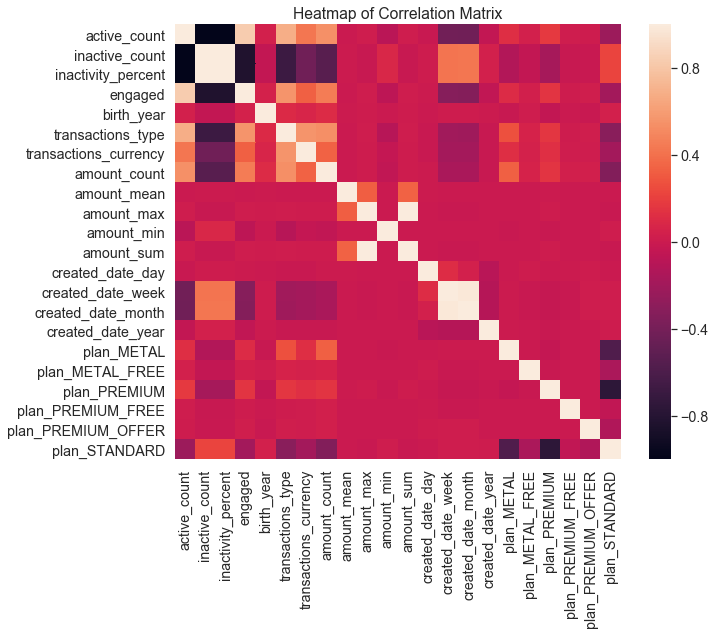

In [49]:
# Create a correlation matrix.
ax = plt.subplots(figsize=(10,8))
corr_result = df_user_activities.corr()
sns.heatmap(corr_result, xticklabels=corr_result.columns.values, yticklabels=corr_result.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr_result

#### Split-out Training and Validation dataset

In [50]:
df_users = df_user_activities[['user_id']]
df_features = df_user_activities.drop(columns=['engaged','user_id','inactivity_percent','inactive_count','active_count'])
df_target = df_user_activities[['engaged']]

the following were dropped beacause of overfitting: 'inactivity_percent','inactive_count','active_count'

#### Feature Selection

In [51]:
#separate into train and test set
feature_train, feature_test, target_train, target_test = train_test_split(
    df_features.values, #predictors
    df_target['engaged'].values, #target
    test_size=0.30,
    random_state=0)

feature_train.shape, feature_test.shape

((13601, 18), (5829, 18))

In [52]:
# for feature selection with RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [53]:
# feature selection
model = LogisticRegression()
rfe = RFE(model,15)
fit = rfe.fit(abs(feature_train), target_train)
print("Num Features:")
print(fit.n_features_)

print("Selected Features:")
print(fit.support_)

print("Feature Ranking: %s")
print(fit.ranking_)

Num Features:
15
Selected Features:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True False False  True]
Feature Ranking: %s
[1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 4 3 1]


In [54]:
# this is how we can make a list of the selected features
selected_feat = df_features.columns[(fit.support_)]
selected_feat

Index(['birth_year', 'transactions_type', 'transactions_currency',
       'amount_count', 'amount_mean', 'amount_max', 'amount_min', 'amount_sum',
       'created_date_day', 'created_date_week', 'created_date_month',
       'created_date_year', 'plan_METAL', 'plan_PREMIUM', 'plan_STANDARD'],
      dtype='object')

#### Evaluate Algorithms: Baseline
To know thet algorithms will do well on this dataset, a 10-fold cross-validation will be used on the dataset and the algorithms will be evaluated using the `accuracy and f1 metric`.

In [69]:
# Test options and evaluation metric
num_folds = 20
seed = 42
scoring = 'f1'
kfold = KFold(n_splits=num_folds)

In [70]:
#separate into train and test set
feature_train, feature_test, target_train, target_test = train_test_split(
    df_features[['birth_year', 'transactions_type', 'transactions_currency',
                'amount_count', 'amount_mean', 'amount_max', 'amount_min', 'amount_sum',
                'created_date_day', 'created_date_month','created_date_year', 'plan_STANDARD']].values, #predictors
    df_target['engaged'].values, #target
    test_size=0.30,
    random_state=0)

feature_train.shape, feature_test.shape

((13601, 12), (5829, 12))

#### DecisionTreeClassifier Model
The model is easy to understand, visualize, interpret, and manipulate

In [71]:
dtc = DecisionTreeClassifier(random_state=seed)
dtc_result = cross_val_score(dtc, feature_train, target_train, cv=kfold, scoring=scoring)
dtc_result.mean()

0.7910205420472018

In [74]:
dtc = dtc.fit(feature_train, target_train)

# predict the label on the traning data
predict_train = dtc.predict(feature_train)
train_score = f1_score(y_true= target_train, y_pred= predict_train)

pred = dtc.predict(feature_test)
test_score = f1_score(y_true= target_test, y_pred= pred)
print ("---Decision Tree Classifier Model---")
print("f1-score(train): ", train_score)
print("f1-score(test): ", test_score)
print('')
dtc_roc_auc = roc_auc_score(target_test, dtc.predict(feature_test))
print(classification_report(target_test, dtc.predict(feature_test)))

---Decision Tree Classifier Model---
f1-score(train):  1.0
f1-score(test):  0.81094432832985

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3212
           1       0.81      0.82      0.81      2617

    accuracy                           0.83      5829
   macro avg       0.83      0.83      0.83      5829
weighted avg       0.83      0.83      0.83      5829



#### RandomForestClassifier Model
The model is interpretable, renders feature importance and less data pre-processing required

In [75]:
rfc = RandomForestClassifier(random_state=seed)
rfc_result = cross_val_score(rfc, feature_train, target_train, cv=kfold, scoring=scoring)
rfc_result.mean()

0.8512830712065165

In [78]:
rfc = rfc.fit(feature_train, target_train)
# predict the label on the traning data
predict_train = rfc.predict(feature_train)
train_score = f1_score(y_true= target_train, y_pred= predict_train)

pred = rfc.predict(feature_test)
test_score = f1_score(y_true= target_test, y_pred= pred)
print ("---Random Forest Classifier Model---")
print("f1-score(train): ", train_score)
print("f1-score(test): ", test_score)
print('')
rfc_roc_auc = roc_auc_score(target_test, rfc.predict(feature_test))
print(classification_report(target_test, rfc.predict(feature_test)))

---Random Forest Classifier Model---
f1-score(train):  1.0
f1-score(test):  0.8571428571428571

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3212
           1       0.85      0.87      0.86      2617

    accuracy                           0.87      5829
   macro avg       0.87      0.87      0.87      5829
weighted avg       0.87      0.87      0.87      5829



#### Gradient Boosting Classifier Model
This model provides predictive accuracy, provides several hyperparameter tuning options, works great with categorical and numerical values as is.

In [79]:
gbc = GradientBoostingClassifier(random_state=seed)
gbc_result = cross_val_score(gbc, feature_train, target_train, cv=kfold, scoring=scoring)
gbc_result.mean()

0.8583485398778764

In [80]:
gbc = gbc.fit(feature_train, target_train)
# predict the label on the traning data
predict_train = gbc.predict(feature_train)
train_score = f1_score(y_true= target_train, y_pred= predict_train)

pred = gbc.predict(feature_test)
test_score = f1_score(y_true= target_test, y_pred= pred)
print ("---Gradient Boosting Classifier Model---")
print("f1-score(train): ", train_score)
print("f1-score(test): ", test_score)
print('')
gbc_roc_auc = roc_auc_score(target_test, gbc.predict(feature_test))
print(classification_report(target_test, gbc.predict(feature_test)))

---Gradient Boosting Classifier Model---
f1-score(train):  0.8677282547811475
f1-score(test):  0.8645500657523953

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      3212
           1       0.85      0.88      0.86      2617

    accuracy                           0.88      5829
   macro avg       0.87      0.88      0.88      5829
weighted avg       0.88      0.88      0.88      5829



#### ROC Graph

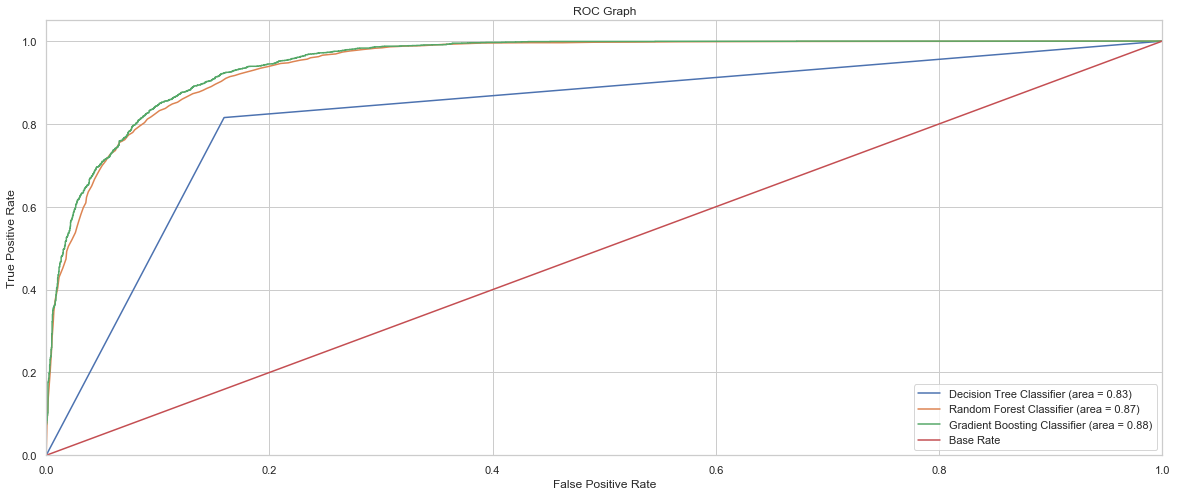

In [81]:
# Create ROC Graph
dtc_fpr, dtc_tpr, dtc_thresholds = roc_curve(target_test, dtc.predict_proba(feature_test)[:,1])
rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(target_test, rfc.predict_proba(feature_test)[:,1])
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(target_test, gbc.predict_proba(feature_test)[:,1])

plt.figure(figsize=(20,8))

# Plot Decision Tree Classifier ROC
plt.plot(dtc_fpr, dtc_tpr, label='Decision Tree Classifier (area = %0.2f)' % dtc_roc_auc)

# Plot Random Forest Classifier ROC
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier (area = %0.2f)' % rfc_roc_auc)

# Plot Gradient Boosting Classifier ROC
plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Classifier (area = %0.2f)' % gbc_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")

plt.show()

The ROC curve above shows the True positive and False positive rates of each model with Gradient Boosting Classifier having the best outcome.

#### Model Tuning
GradientBoostingClassifier

In [64]:
# Set values to use in tuning the model
param_test = {'max_depth':range(5,16,2), 'min_samples_split':range(800,1001,200)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=10)
gsearch.fit(feature_train, target_train)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 7, 'min_samples_split': 1000}, 0.9482834117275925)

In [82]:
# Make predictions on validation dataset
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,min_samples_split=1000,min_samples_leaf=1,max_depth=9)
model.fit(feature_train, target_train)
predictions = model.predict(feature_test)
print('f1-score')
print(f1_score(target_test, predictions))
print(' ')
print('confusion_matrix')
print(confusion_matrix(target_test, predictions))
print(' ')
print('classification_report')
print(classification_report(target_test, predictions))

f1-score
0.8641743377794476
 
confusion_matrix
[[2806  406]
 [ 317 2300]]
 
classification_report
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      3212
           1       0.85      0.88      0.86      2617

    accuracy                           0.88      5829
   macro avg       0.87      0.88      0.88      5829
weighted avg       0.88      0.88      0.88      5829



More tuning needs to be done to get optimal results

#### Feature Importances

In [83]:
# Get Feature Importances
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = ['birth_year', 'transactions_type', 'transactions_currency',
                                            'amount_count', 'amount_mean', 'amount_max', 'amount_min', 'amount_sum',
                                            'created_date_day', 'created_date_month','created_date_year', 'plan_STANDARD'],
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances

,index,importance
0,amount_count,0.722139
1,created_date_month,0.192925
2,amount_sum,0.019051
3,amount_mean,0.014955
4,amount_max,0.014294
5,amount_min,0.011001
6,birth_year,0.008303
7,plan_STANDARD,0.006763
8,created_date_year,0.004703
9,transactions_type,0.002597


The above shows a table of features with the corresponding importance scores

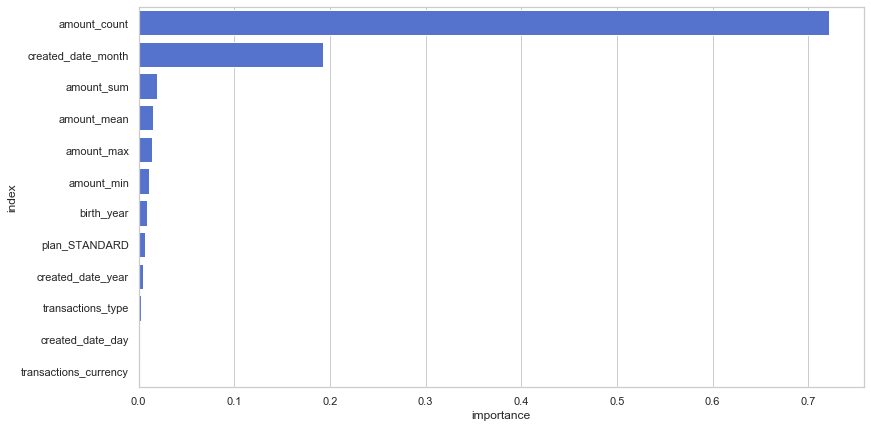

In [86]:
# Plot the Feature Importance
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances,
            label="Total", color="royalblue")

From the plot above the 2 most important features in the selected set of features are amount_count and created_date_month.

In [85]:
# save model
import joblib
joblib.dump(model,'../models/gradient_boosting_classifier_model.pkl')

['../models/gradient_boosting_classifier_model.pkl']